##Model background
Here is an example based on the Henry saltwater intrusion problem.  The synthetic model is a 2-dimensional SEAWAT model (X-Z domain) with 1 row, 120 columns and 20 layers.  The left boundary is a specified flux of freshwater, the right boundary is a specified head and concentration saltwater boundary.  The model has two stress periods: an initial steady state (calibration) period, then a transient period with less flux (forecast).  

<img src="henry/domain.png" width=800/>

The inverse problem includes 601 parameters (600 hydraulic conductivity pilot points and 1 specified flux multiplier) and 36 obseravtions (21 heads and 15 concentrations) measured at the end of the steady state calibration period.  Additional, zero-weight observations of head and concentration are also available at each observation location at the end of the transient forecast period as is the distance from the left edge of the domain to the 1%, 10% and 50% saltwater contours in the basal model layer at the end of the forecast stress period.  These distances, named ```pd_one```, ```pd_ten``` and ```pd_half``` are the forecasts we are interested in.  I previously calculated the jacobian matrix, which is in the `henry/` folder, along with the PEST control file.

Note we will leave out the 1 specified flux multiplier since it is something that wouldn't typically be estimated.  


##Using `pyemu`

In [2]:
%pylab inline
import os
import numpy as np
import pyemu
reload(pyemu)

Populating the interactive namespace from numpy and matplotlib


<module 'pyemu' from '/Users/jwhite/anaconda/lib/python2.7/site-packages/pyemu.pyc'>

First create a linear_analysis object.  We will use `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [3]:
forecasts = ["pd_one","pd_ten","pd_half"]
la = pyemu.schur(jco=os.path.join("henry", "pest.jco"), forecasts=forecasts)


2015-03-30 14:24:07.825889 starting: pre-loading base components
2015-03-30 14:24:07.825963 starting: loading jco: henry/pest.jco
2015-03-30 14:24:07.833101 finished: loading jco: henry/pest.jco took: 0:00:00.007138
2015-03-30 14:24:07.833165 starting: loading pst: henry/pest.pst
2015-03-30 14:24:07.858581 finished: loading pst: henry/pest.pst took: 0:00:00.025416
2015-03-30 14:24:07.858635 starting: loading parcov
2015-03-30 14:24:07.941440 finished: loading parcov took: 0:00:00.082805
2015-03-30 14:24:07.941855 starting: loading obscov
2015-03-30 14:24:07.958366 finished: loading obscov took: 0:00:00.016511
2015-03-30 14:24:07.958417 starting: loading forecasts
2015-03-30 14:24:07.967725 finished: loading forecasts took: 0:00:00.009308
2015-03-30 14:24:07.967787 finished: pre-loading base components took: 0:00:00.141898
2015-03-30 14:24:07.967803 starting: dropping prior information
2015-03-30 14:24:07.967862 starting: removing 601 prior info from jco, pst, and obs cov
2015-03-30 14:

The screen output can be redirected to a log file by passing a file name to the `verbose` keyword argument.  Or screen output can be stopped by passing `False` to the `verbose` argument

In [4]:
la = pyemu.schur(jco=os.path.join("henry", "pest.jco"), forecasts=forecasts,verbose=False)

Here we drop the 1 specified flux multiplier parameter named ```mult1```.  We ```.get()``` a new ```pyemu``` instance without the ```mult1``` parameter

In [5]:
pnames = la.parcov.row_names
pnames.remove("mult1")
la = la.get(par_names=pnames,obs_names=la.obscov.row_names)

We can inspect the parcov and obscov attributes by saving them to files.  We can save them PEST-compatible ASCII or binary matrices (`.to_ascii()` or `.to_binary()`), PEST-compatible uncertainty files (`.to_uncfile()`), or simply as numpy ASCII arrays (`numpy.savetxt()`).  In fact, all matrix and covariance objects (including the forecasts) have these methods.  


In [6]:
la.parcov.to_uncfile(os.path.join("henry", "parcov.unc"), covmat_file=os.path.join("henry","parcov.mat"))

When saving an uncertainty file, if the covariance object is diagonal (`self.isdiagonal == True`), then you can force the uncertainty file to use standard deviation blocks instead of covariance matrix blocks by explicitly passing `covmat_file` as `None`:

In [7]:
la.obscov.to_uncfile(os.path.join("henry", "obscov.unc"), covmat_file=None)

##Posterior parameter uncertainty analysis
Let's calculate and save the posterior parameter covariance matrix:

In [8]:
la.posterior_parameter.to_ascii(os.path.join("henry", "posterior.mat"))

You can open this file in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated method only require access:


In [9]:
la.posterior_parameter.to_dataframe() #look so nice in the notebook

,kr01c01,kr01c02,kr01c03,kr01c04,kr01c05,kr01c06,kr01c07,kr01c08,kr01c09,kr01c10,...,kr10c51,kr10c52,kr10c53,kr10c54,kr10c55,kr10c56,kr10c57,kr10c58,kr10c59,kr10c60
kr01c01,0.25,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
kr01c02,0.00,0.25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
kr01c03,0.00,0.00,2.500000e-01,-2.120772e-71,-2.120779e-71,-3.976443e-71,-3.976457e-71,-5.832128e-71,-7.952907e-71,-9.808591e-71,...,1.481887e-66,1.419379e-66,1.121441e-66,2.872438e-67,-1.390407e-67,-5.852652e-68,-1.624500e-67,-2.572703e-67,-3.249292e-67,-2.677791e-67
kr01c04,0.00,0.00,-2.120772e-71,2.500000e-01,-2.120779e-71,-3.976443e-71,-3.976457e-71,-5.832128e-71,-7.952907e-71,-9.808591e-71,...,1.481887e-66,1.419379e-66,1.121441e-66,2.872438e-67,-1.390407e-67,-5.852652e-68,-1.624500e-67,-2.572703e-67,-3.249292e-67,-2.677791e-67
kr01c05,0.00,0.00,-2.120779e-71,-2.120779e-71,2.500000e-01,-4.003294e-71,-4.003314e-71,-5.858988e-71,-7.979777e-71,-9.862313e-71,...,1.474511e-66,1.409016e-66,1.110482e-66,2.840303e-67,-1.373470e-67,-5.757165e-68,-1.597290e-67,-2.531075e-67,-3.198070e-67,-2.636075e-67
kr01c06,0.00,0.00,-3.976443e-71,-3.976443e-71,-4.003294e-71,2.500000e-01,-2.120759e-53,-2.120759e-53,-2.120759e-53,-2.120759e-53,...,1.827789e-48,1.718983e-48,1.278951e-48,2.934304e-49,-1.467601e-49,-1.019464e-50,-7.108351e-50,-1.471582e-49,-2.108833e-49,-1.827076e-49
kr01c07,0.00,0.00,-3.976457e-71,-3.976457e-71,-4.003314e-71,-2.120759e-53,2.500000e-01,-2.120759e-53,-2.120759e-53,-2.120759e-53,...,1.827789e-48,1.718983e-48,1.278951e-48,2.934304e-49,-1.467601e-49,-1.019464e-50,-7.108351e-50,-1.471582e-49,-2.108833e-49,-1.827076e-49
kr01c08,0.00,0.00,-5.832128e-71,-5.832128e-71,-5.858988e-71,-2.120759e-53,-2.120759e-53,2.500000e-01,-3.313686e-43,-3.313686e-43,...,5.312355e-39,5.677000e-41,-5.661915e-39,-2.381003e-40,3.606592e-39,2.175123e-39,4.169310e-39,5.605063e-39,6.603782e-39,5.316764e-39
kr01c09,0.00,0.00,-7.952907e-71,-7.952907e-71,-7.979777e-71,-2.120759e-53,-2.120759e-53,-3.313686e-43,2.500000e-01,-3.313686e-43,...,5.312355e-39,5.677000e-41,-5.661915e-39,-2.381003e-40,3.606592e-39,2.175123e-39,4.169310e-39,5.605063e-39,6.603782e-39,5.316764e-39
kr01c10,0.00,0.00,-9.808591e-71,-9.808591e-71,-9.862313e-71,-2.120759e-53,-2.120759e-53,-3.313686e-43,-3.313686e-43,2.500000e-01,...,9.003806e-31,8.288189e-31,5.878149e-31,1.307611e-31,-5.558787e-32,1.312539e-32,6.026793e-34,-2.463057e-32,-4.895777e-32,-4.660439e-32


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty

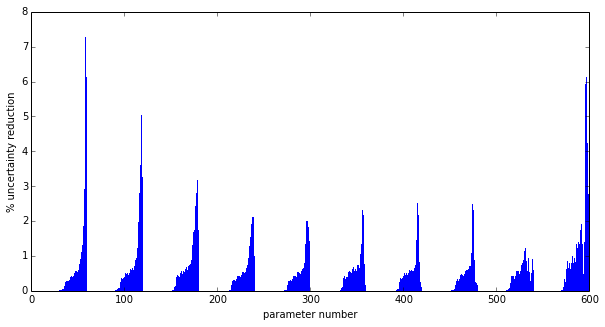

In [11]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
#the prior is already diagonal
prior_var = la.parcov.x[:,0]
#extract the diagaonl of the posterior
post_var = np.diag(la.posterior_parameter.x)
#calculate the % uncertainty reduction 
ureduce = 100.0 * (1.0 - (post_var/prior_var))
index = np.arange(600)
width = 1.0
ax.bar(index,ureduce,width=width,facecolor='b',edgecolor="none")
ax.set_ylabel("% uncertainty reduction")
ax.set_xlabel("parameter number")
plt.show()

We can see that the at most, the uncertainty of any one of the 600 parameters is only reduced by 7% and the uncertainty of many parameters has not been reduced at all, meaning these parameters are not informed by the observations.  

##Prior forecast uncertainty
Now let's examine the prior variance of the forecasts:

In [15]:
prior = la.prior_forecast
print prior # dict keyed on forecast name


{'pd_half': 0.073927415271761526, 'pd_ten': 0.075940151522232782, 'pd_one': 0.040282634615793532}


Sometimes, it is more intuitive to think in terms of standard deviation, which in this case has units of ```meters``` and can be thought of as the "+/-" around the model-predicted distance from the left edge of the domain to the three saltwater concentration contours

In [16]:
for pname,var in la.prior_forecast.iteritems():
    print pname,np.sqrt(var)

pd_half 0.271895964059
pd_ten 0.275572407041
pd_one 0.200705342768


##Posterior forecast uncertainty
Now, let's calculate the posterior uncertainty (variance) of each forecast:

In [17]:
post = la.posterior_forecast
for pname,var in post.iteritems():
    print pname,np.sqrt(var)

pd_half 0.215954619686
pd_ten 0.214020174233
pd_one 0.153780285792


That's it - we have completed linear-based uncertainty analysis for a model with 600 parameters and we completed it before actual inversion so we can estimate the worth of continuing and actually completing the expense inversion process!  We can see that the data we have provide atleast some conditioning to each of these forecasts, indicating that the history-matching process is valuable:

In [18]:
print "{0:15s} {1:>10s} {2:>10s} {3:>10s}".format("forecast","prior var","post var","% reduced")
for pname in prior.keys():
    uncert_reduction = 100.0 * ((prior[pname] - post[pname]) / prior[pname])
    print "{0:15s} {1:10.3f} {2:10.3f} {3:10.3f}".format(pname,prior[pname],post[pname],uncert_reduction)
    #print pname,prior[pname],post[pname],uncert_reduction

forecast         prior var   post var  % reduced
pd_half              0.074      0.047     36.916
pd_ten               0.076      0.046     39.683
pd_one               0.040      0.024     41.294


It is interesting that the uncertainty of the forecasts is reduced substantially even though the uncertainty for any one parameter is only slightly reduced.  This is because the right combinations of forecast-sensitive parameters are being informed by the observations.

##Data worth
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  In `pyemu`, we define forecast worth as:

$100.0 * \frac{\text{new variance} - \text{base variance}}{\text{new variance}}$

where "base variance" is the forecast variance using all the observations and "new variance" is the forecast variance with some observations left out.

First, lets see if the heads or the concentrations are more important:

In [25]:
head_names, conc_names = [], []
for obs_name in la.jco.obs_names:
    if obs_name.startswith('c'):
        conc_names.append(obs_name)
    elif obs_name.startswith('h'):
        head_names.append(obs_name)

Now let's get the worth of heads:

In [26]:
print la.importance_of_observations(head_names)

{'pd_one': 12.882529434270037, 'pd_ten': 12.758212084044796, 'pd_half': 10.98472432540148}


And now the worth of the concentrations:

In [27]:
print la.importance_of_observations(conc_names)

{'pd_one': 5.3565575884342085, 'pd_ten': 4.8902407990235224, 'pd_half': 4.7112176015858838}


So, it looks like the heads and concentrations are both important for reducing the posterior uncertainty of the forecasts.  Let's look at the importance of each individual observation with respect to reducting posterior forecast uncertainty.  Note the observations with an `_2` are actually forecasts but are carried in the pest control file as observations with zero weight. Thats why those observations don't reduce uncertainty.  

In [28]:
# create a structure to hold the results
results = {}
for name in forecasts:
    results[name.lower()] = []
# cycle through all of the obs    
for oname in la.jco.obs_names:
    r = la.importance_of_observations(oname)
    #print oname,r
    for name,value in r.iteritems():
        results[name].append(value)


a simple plot of the data worth analysis

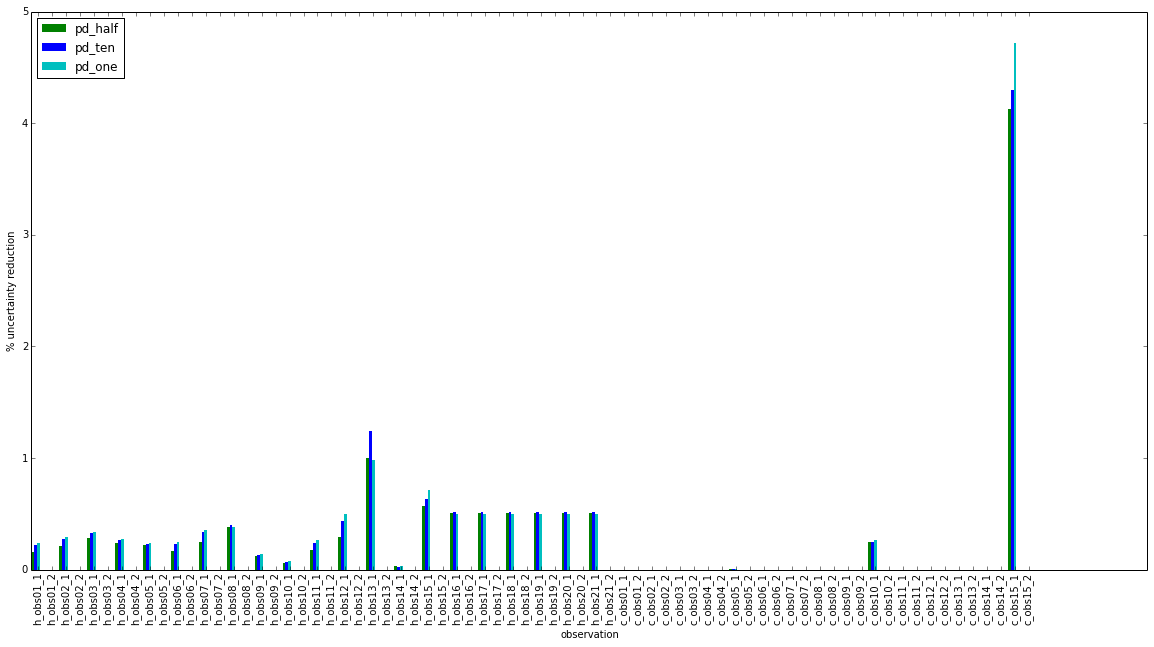

In [29]:
import pylab as plt
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
idx = np.arange(len(la.jco.obs_names))
width = 0.2
colors = ['g', 'b', 'c']
for i,name in enumerate(results.keys()):
    ax.bar(idx + (i * width), results[name], width=width, edgecolor="none", facecolor=colors[i], label=name)
ax.set_xticks(idx + 0.5)
ax.set_xticklabels(la.jco.obs_names, rotation=90)
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_ylabel("% uncertainty reduction")
ax.set_xlabel("observation")
ax.legend(loc="upper left")
plt.show()